## PIPELINE

In [1]:
import os
import numpy as np
import PIL
import cv2
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import time

In [2]:
# Below value to be changed only 
input_shape = (224, 224, 3)
algorithm = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
saving_model_name = 'mobilenet'

In [3]:
# Mapping of class indices to labels
int_to_label = {v: k for k, v in {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}.items()}

In [4]:
# Define paths and file names
folder_path = "C:/Users/ys726/Desktop/DL/datasets/intel"
file_x = 'X_test.npy'
file_y = 'y_test.npy'

In [5]:
# Custom function for loading and preprocessing data
def load_and_preprocess_data():
    path_x = os.path.join(folder_path, file_x)
    path_y = os.path.join(folder_path, file_y)

    if os.path.exists(path_x) and os.path.exists(path_y):
        X = np.load(path_x)
        y = np.load(path_y)
        print("Files loaded successfully.")
    else:
        train_dir = pathlib.Path("C:/Users/ys726/Desktop/DL/datasets/intel/seg_test")

        intel_image_dict = {
            'buildings': list(train_dir.glob('buildings/*')),
            'forest': list(train_dir.glob('forest/*')),
            'glacier': list(train_dir.glob('glacier/*')),
            'mountain': list(train_dir.glob('mountain/*')),
            'sea': list(train_dir.glob('sea/*')),
            'street': list(train_dir.glob('street/*')),
        }

        intel_labels_dict = {
            'buildings': 0,
            'forest': 1,
            'glacier': 2,
            'mountain': 3,
            'sea': 4,
            'street': 5
        }

        X, y = [], []
        for name, images in intel_image_dict.items():
            for image in images:
                img = cv2.imread(str(image))
                resized_image = cv2.resize(img, (224, 224))
                X.append(resized_image)
                y.append(intel_labels_dict[name])

        X = np.array(X) / 255.0
        y = np.array(y)

        np.save(path_x, X)
        np.save(path_y, y)
        print("Data processed and saved.")

    return X, y

In [6]:
# Custom function for creating the model
def create_model(input_shape):
    model = algorithm
    model.trainable = False

    model = tf.keras.Sequential([
        model,
        layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        layers.Dense(6, activation="softmax")
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [7]:
# Custom function for training the model
def train_model(X_train, y_train, epochs_gpu=2, epochs_cpu=1):
    start_time = time.time()
    
    try:
        with tf.device('/GPU:0'):
            model = create_model((224, 224, 3))
            model.fit(X_train, y_train, epochs=epochs_gpu)
            end_time = time.time()
            print("GPU Execution time:", end_time - start_time)
            return model
    except tf.errors.InvalidArgumentError:
        print("GPU not available. Training on CPU...")

    with tf.device('/CPU:0'):
        model = create_model((224, 224, 3))
        model.fit(X_train, y_train, epochs=epochs_cpu)
        end_time = time.time()
        print("CPU Execution time:", end_time - start_time)
        return model

In [8]:
# Custom function for evaluating the model
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

In [9]:
def plot_sample(X, label, title):
    plt.imshow(X)
    plt.xlabel(int_to_label[label])
    plt.title(title)

In [10]:
# Prediction function with image display
def predict_image(model, image_path, actual_label=None):
    # Preprocess the image
    origonal_image = PIL.Image.open(image_path)
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (224, 224))
    img_normalized = img_resized / 255.0
    img_expanded = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

    # Make a prediction
    predictions = model.predict(img_expanded)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get the readable label
    actual_label = image_path.split('/')[-2]
    predicted_label = int_to_label[predicted_class]

    # Plot the original image
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(origonal_image)
    plt.title('Original Image')
    plt.xlabel(actual_label)

    # Plot the predicted image
    plt.subplot(1, 2, 2)
    plot_sample(img_resized, predicted_class, 'Predicted Image')
    
    plt.tight_layout()
    plt.show()    

    return predicted_label


In [11]:
# Main pipeline function
def main_pipeline():
    X, y = load_and_preprocess_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    model = train_model(X_train, y_train)
    evaluate_model(model, X_test[:100], y_test[:100])

    # Saving the model
    model.save(f'{saving_model_name}.h5')
    print(f"Model saved as {saving_model_name}.h5")
    
    return model

In [12]:
final_model = main_pipeline()

Files loaded successfully.
Epoch 1/2
57/57 [==============================] - 9s 43ms/step - loss: 2.3189 - accuracy: 0.7600
Epoch 2/2
57/57 [==============================] - 5s 87ms/step - loss: 0.3715 - accuracy: 0.9456
GPU Execution time: 16.033048152923584
4/4 [==============================] - 1s 55ms/step - loss: 1.0900 - accuracy: 0.8700
Test Loss: 1.0900
Test Accuracy: 0.8700
Model saved as mobilenet.h5


1/1 [==============================] - 1s 515ms/step


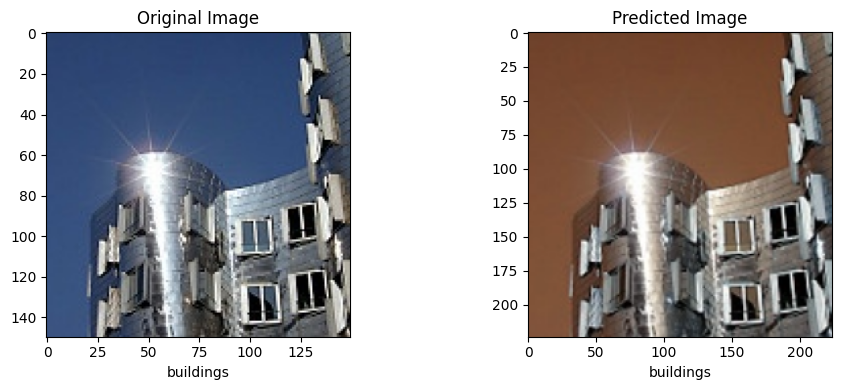

1/1 [==============================] - 0s 35ms/step


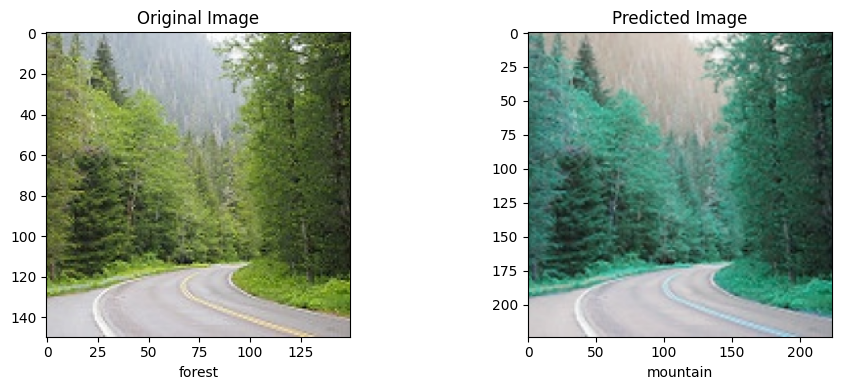

1/1 [==============================] - 0s 27ms/step


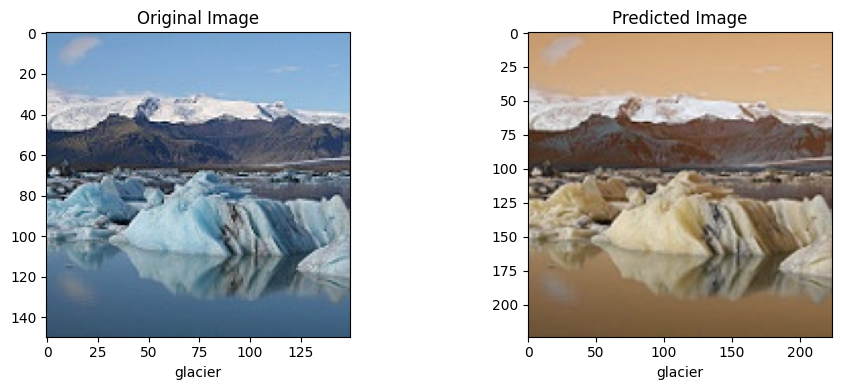

1/1 [==============================] - 0s 33ms/step


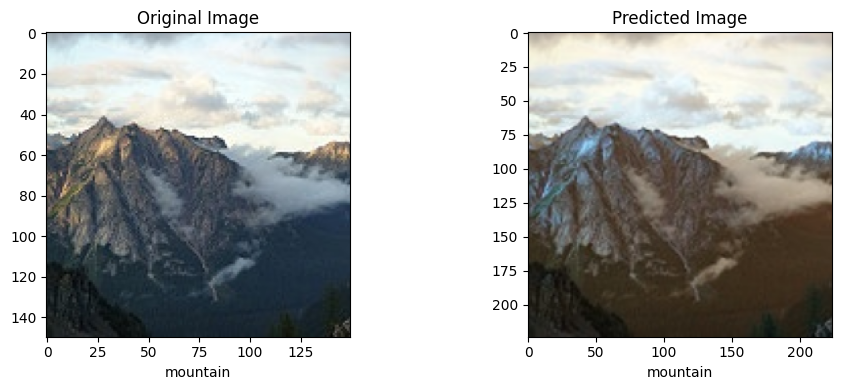

1/1 [==============================] - 0s 27ms/step


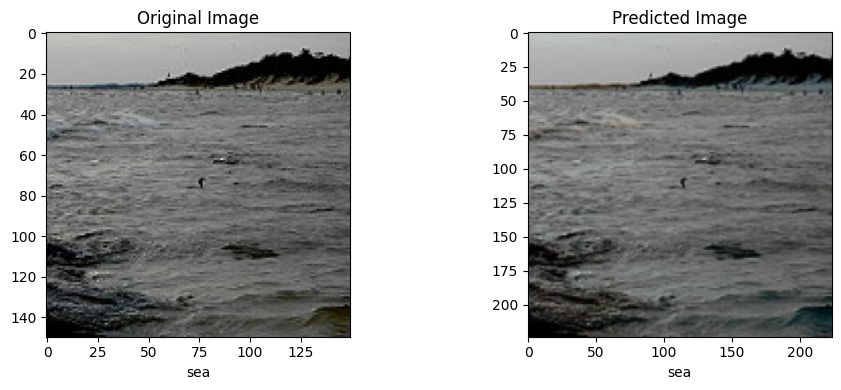

1/1 [==============================] - 0s 50ms/step


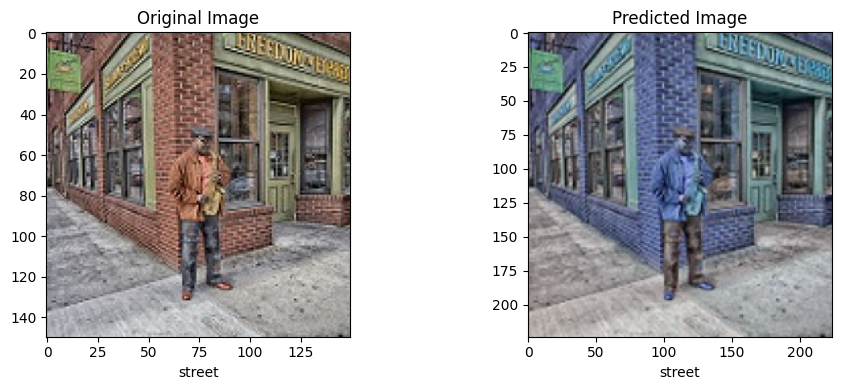

In [14]:
# Example usage of prediction function
paths = [
    "C:/Users/ys726/Desktop/DL/datasets/intel/seg_train/buildings/1877.jpg",
    "C:/Users/ys726/Desktop/DL/datasets/intel/seg_train/forest/430.jpg", 
    "C:/Users/ys726/Desktop/DL/datasets/intel/seg_train/glacier/417.jpg",
    "C:/Users/ys726/Desktop/DL/datasets/intel/seg_train/mountain/6932.jpg",
    "C:/Users/ys726/Desktop/DL/datasets/intel/seg_train/sea/11667.jpg",
    "C:/Users/ys726/Desktop/DL/datasets/intel/seg_train/street/8690.jpg"
]

# Process and plot images
for path in paths:
    predict_image(final_model, path)

## Load the model

In [ ]:
from tensorflow.keras.models import load_model
model_path = 'dummy.h5'
model_load = load_model(model_path)

In [ ]:
## Run Below Function before predicting
#Predict Image
#int_to_label
#plot_sample

In [ ]:
a = "C:/Users/ys726/Desktop/DL/datasets/intel/seg_train/sea/224.jpg"
predict_image(model_load, a)